<a href="https://colab.research.google.com/github/mervenurerdogan/AfetKayitEkrani/blob/master/BrainTumorSegmentationMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import PIL

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [6]:

%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [7]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls


kaggle_3m  kaggle.json	lgg-mri-segmentation  lgg-mri-segmentation.zip	models


In [9]:
from zipfile import ZipFile
file_name="lgg-mri-segmentation.zip"

In [10]:
#with ZipFile(file_name,'r') as zip:  
 # zip.extractall()
  #print('done')

In [11]:
path=Path("/content/gdrive/MyDrive/Kaggle/kaggle_3m")

In [12]:
path.ls()

(#111) [Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_4941_19960909'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_4942_19970222'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_4943_20000902'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_4944_20010208'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_5393_19990606'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_5395_19981004'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_5396_20010302'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_5397_20010315'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_6186_20000601'),Path('/content/gdrive/MyDrive/Kaggle/kaggle_3m/TCGA_CS_6188_20010812')...]

In [13]:
fname=get_image_files(path)

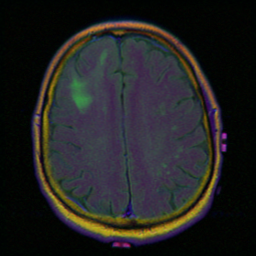

In [14]:
image=PILImage.create(fname[15])
image # verisetimizden bir im

In [15]:
def get_mask(o) : return o.parent/f'{o.stem}_mask{o.suffix}'

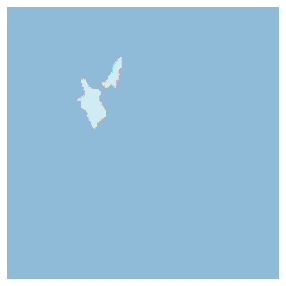

In [16]:
image_mask=PILMask.create(get_mask(fname[15]))
image_mask.show(figsize=(5,5), alpha=0.5)

In [17]:
def get_files(o):
  x=L()
  fnames=get_image_files(o)
  for f in fnames:
    if not f.match('*mask.tif'):
      x.append(f)
  return x

In [18]:
codes=['N','Y']

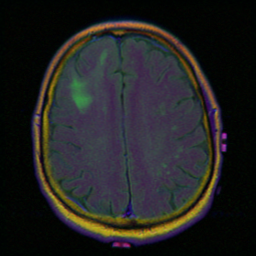

In [19]:
image

In [20]:
brain_block=DataBlock(blocks=(ImageBlock,MaskBlock(codes=codes)),
                        get_items=get_files,
                        splitter=RandomSplitter(seed=68),
                        get_y=get_mask,
                        item_tfms=Resize(128, method="squish"),
                        batch_tfms=[IntToFloatTensor(div_mask=255.0),*aug_transforms(size=112), Normalize.from_stats(*imagenet_stats)]
                        
                      
                        )

In [21]:
dls=brain_block.dataloaders(path,bs=16)

In [22]:
dls.vocab=codes
dls.vocab

['N', 'Y']

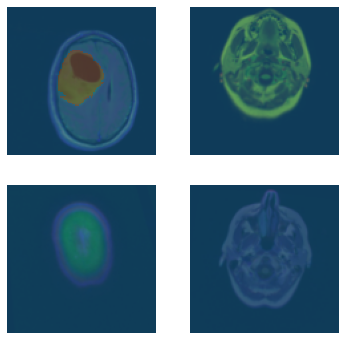

In [23]:
dls.show_batch(max_n=4)

Eğitim için dynamic unet yapısını oluşturuyoruz

In [24]:
dynamic_learn= unet_learner(dls, resnet50, metrics=Dice(), loss_func=CrossEntropyLossFlat(axis=1))

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=4.786300905834651e-06)

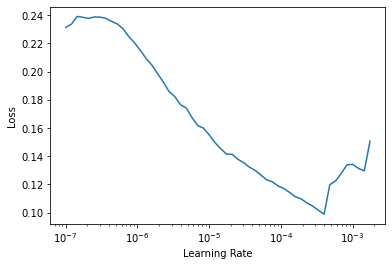

In [25]:

dynamic_learn.lr_find()

In [26]:
lr=1e-4

In [27]:
dynamic_learn.fit_flat_cos(5,slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.017785,0.011181,0.777110,17:27
1,0.011462,0.009098,0.825911,16:27
2,0.009684,0.010245,0.823096,16:27
3,0.007809,0.011598,0.809830,16:28
4,0.006814,0.006606,0.871545,16:30


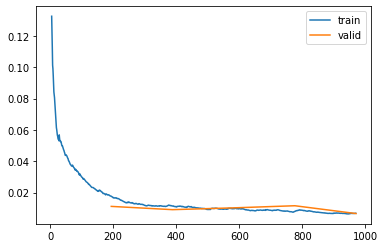

In [28]:

dynamic_learn.recorder.plot_loss()

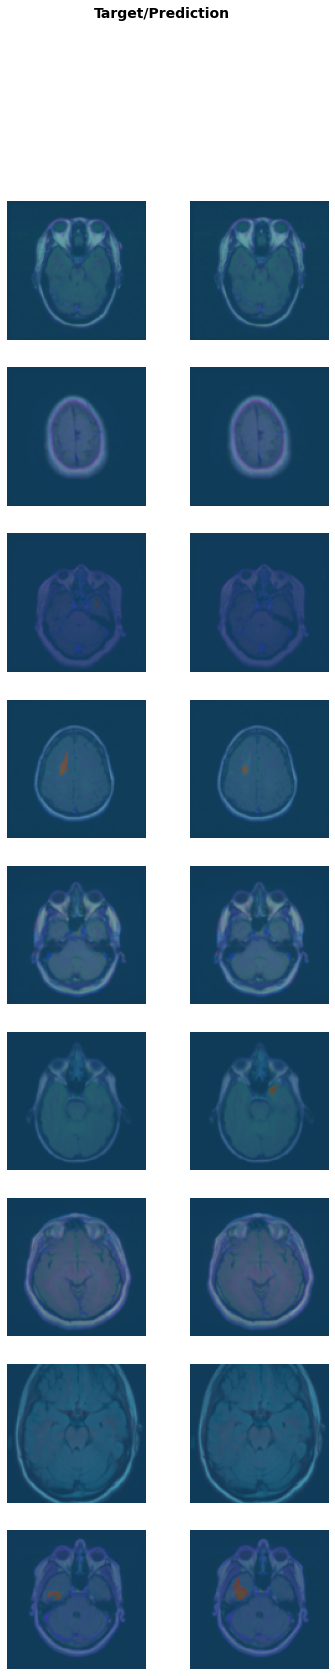

In [31]:
dynamic_learn.show_results()

In [51]:
test_path='/content/gdrive/MyDrive/Kaggle/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909'
img_files = get_files(test_path)

In [54]:
def plot_images():
  fig, ax = plt.subplots(3,3, figsize=(10,10), sharex=True, sharey=True)
  for i in range(3):
    img = PILImage.create(img_files[i+2])
    img_mask = PILMask.create(get_mask(img_files[i+2]))
    pred_mask = PILMask.create(dynamic_learn.predict(img)[0])
    ax[i][0].imshow(img)
    ax[i][0].set_title('MRI Scans')

    ax[i][1].imshow(img_mask)
    ax[i][1].set_title('Target')

    ax[i][2].imshow(pred_mask)
    ax[i][2].set_title('Predicted')

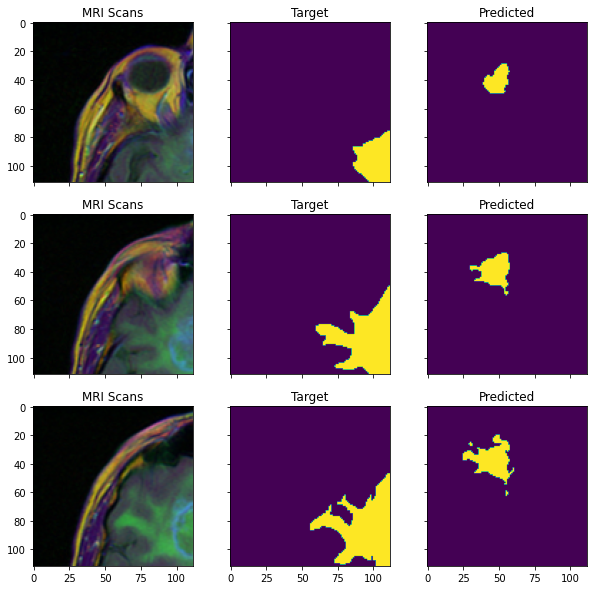

In [55]:
plot_images()